In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = (
    torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
)
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)

In [24]:
dataset_path = "./data/[Data]_Ex1_Auto_MPG_data.csv"
dataset = pd.read_csv(dataset_path)
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


In [25]:
X = dataset.drop(columns="MPG").values
y = dataset["MPG"].values

In [26]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, shuffle=is_shuffle, random_state=random_state
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle
)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(273, 9)
(40, 9)
(79, 9)


In [27]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

print(X_train)

[[-0.84144139 -1.03791712 -1.03812675 ... -0.44426166  1.90449958
  -1.27475488]
 [ 0.36757703  0.36824297  0.22296166 ... -0.44426166 -0.52507231
   0.78446454]
 [-0.84144139 -0.916522   -0.89800582 ... -0.44426166 -0.52507231
   0.78446454]
 ...
 [ 1.57659545  1.30905511  1.34392915 ... -0.44426166 -0.52507231
   0.78446454]
 [ 0.36757703  0.43905678 -0.33752208 ... -0.44426166 -0.52507231
   0.78446454]
 [ 0.36757703  0.62114946 -0.05728021 ... -0.44426166 -0.52507231
   0.78446454]]


In [28]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [29]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [30]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(
            1
        )  # Loại bỏ chiều có kích thước bằng 1 tại chỉ số index 1 -> trả về tensor 1 chiều

In [31]:
input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(
    device
)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [32]:
# Create R2 score function
def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [33]:
# Training
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.float().to(device)
        y_samples = y_samples.float().to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        train_predict += outputs.tolist()
        train_target += y_samples.tolist()
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict).item())
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.float().to(device)
            y_samples = y_samples.float().to(device)

            outputs = model(X_samples)

            loss = criterion(outputs, y_samples)
            val_loss += loss.item()

            val_predict += outputs.tolist()
            val_target += y_samples.tolist()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_r2.append(r_squared(val_target, val_predict).item())


Text(0.5, 1.0, 'Validation R2')

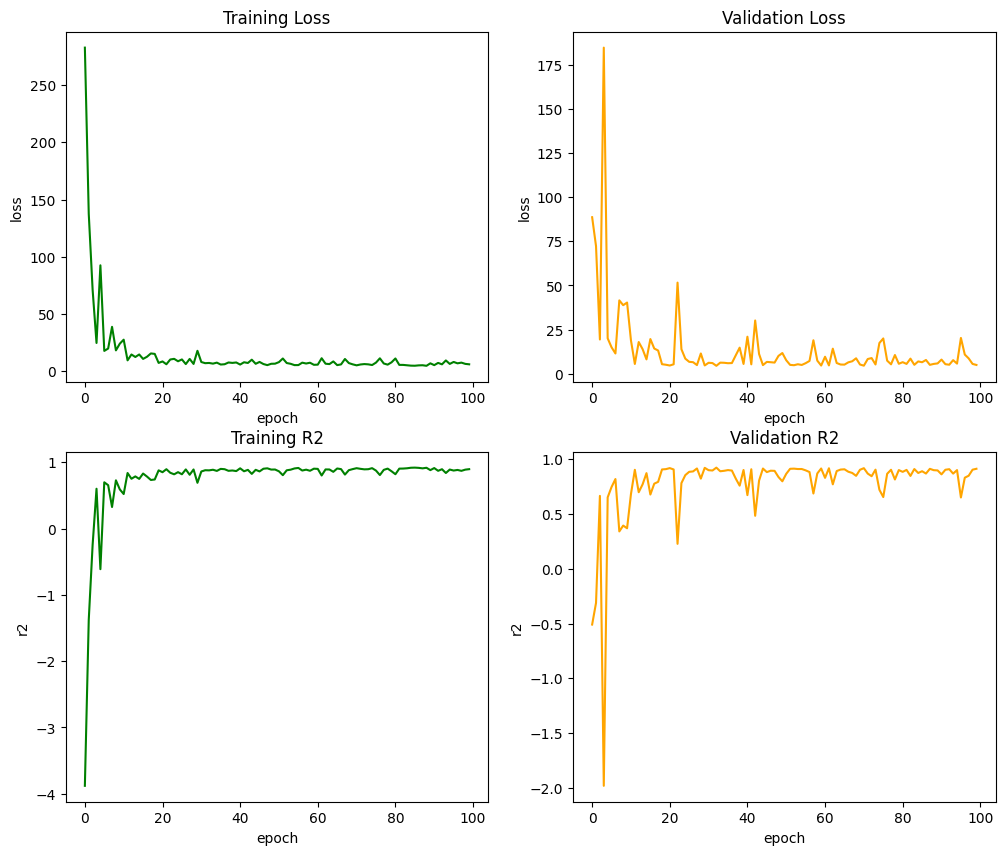

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color="green")
ax[0, 0].set(xlabel="epoch", ylabel="loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(val_losses, color="orange")
ax[0, 1].set(xlabel="epoch", ylabel="loss")
ax[0, 1].set_title("Validation Loss")

ax[1, 0].plot(train_r2, color="green")
ax[1, 0].set(xlabel="epoch", ylabel="r2")
ax[1, 0].set_title("Training R2")

ax[1, 1].plot(val_r2, color="orange")
ax[1, 1].set(xlabel="epoch", ylabel="r2")
ax[1, 1].set_title("Validation R2")

In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    X_val_tensor = torch.from_numpy(X_val).float().to(device)
    y_hat = model(X_val_tensor)
    val_set_r2 = r_squared(y_hat, y_val)
    print("Evaluation on validation set:")
    print(f"R2: {val_set_r2}")

Evaluation on validation set:
R2: 0.8922600746154785
